In [1]:
import os
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import keras
from keras import layers, Input, models
import matplotlib
from matplotlib import font_manager, rc, gridspec
import matplotlib.pyplot as plt
import warnings
import itertools
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow_addons.metrics
import cv2
import random
from tqdm.keras import TqdmCallback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
#warnings.filterwarnings("ignore")

/home/hyunw/.local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/hyunw/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make 

In [2]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
# 환경 설정
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
#print(font_list[:])
%matplotlib inline


In [4]:
import mapply
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=16,
    progressbar=True
)
tqdm.pandas()

font_path = '/usr/share/fonts/NanumGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', family='NanumGothic')

In [5]:
#최초 실행시에만 True
is_first = False

In [6]:
# GPU 메모리 최대 사용을 막기 위한 memory_growth  설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
#최초 실행시 전체 데이터 로드
if is_first:
    df=pd.read_pickle("LSWMD.pkl")
    df.info()

In [8]:
#라벨링 필드 치환을 위한 맵핑 선언
LabelMapping = {
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8
}

In [9]:
#불량 타입에 대한 라벨링 적용
if is_first:
    df['failureNum']=df.failureType
    df = df.replace({'failureNum':LabelMapping})

In [10]:
if is_first:
    print('라벨링이 있는 건수 : ', len(df[(df['failureNum']>=0) & (df['failureNum']<=7)]))
    print('라벨링이 없는 건수 : ', len(df[df['failureNum']==8]))

In [11]:
#학습에 사용될 실제 데이터 로드
if is_first:
    df_wafermap = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_wafermap = df_wafermap.reset_index()
    df_wafermap.to_pickle('LSWMD_wafermap.pkl')
else:
    df_wafermap = pd.read_pickle("LSWMD_wafermap.pkl")

In [12]:
#불량 라벨의 array 데이터를 중첩루프에서 string 추출
df_wafermap['failureType'] = df_wafermap['failureType'].apply(lambda x: list(itertools.chain.from_iterable(x))[0])
df_wafermap['trianTestLabel'] = df_wafermap['trianTestLabel'].apply(lambda x: list(itertools.chain.from_iterable(x))[0])

In [13]:
#불량 패턴만 추출
plt_label_values = np.unique(df_wafermap[(df_wafermap['failureNum']>=0) 
                                         & (df_wafermap['failureNum']<=7)].failureNum, return_counts=True)
df_label_values = df_wafermap[(df_wafermap['failureNum']>=0) & (df_wafermap['failureNum']<=7)]
df_label_values = df_label_values.reset_index()

/tmp/ipykernel_774576/1968714749.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


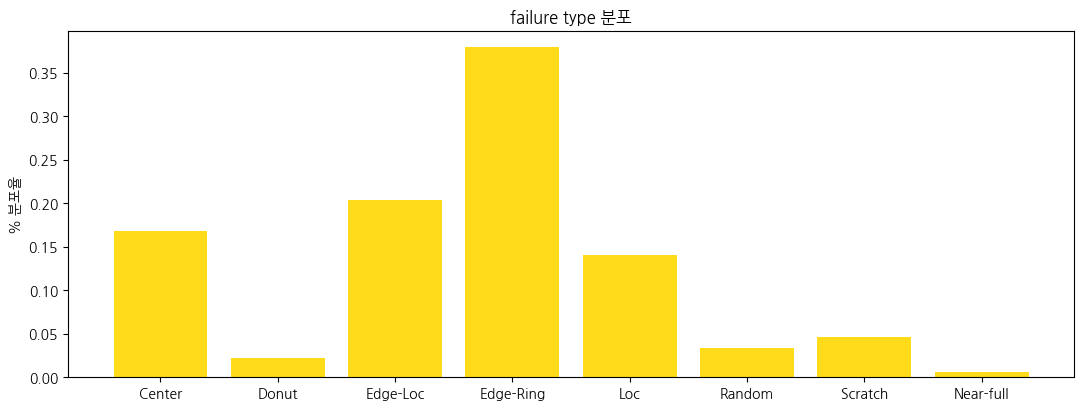

In [14]:
#불량 종류 시각화
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax = plt.subplot(gs[1])
labels = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax.bar(plt_label_values[0],plt_label_values[1]/df_label_values.shape[0], color='gold', align='center', alpha=0.9)
ax.set_title("failure type 분포")
ax.set_ylabel("% 분포율")
ax.set_xticklabels(labels)
plt.show()

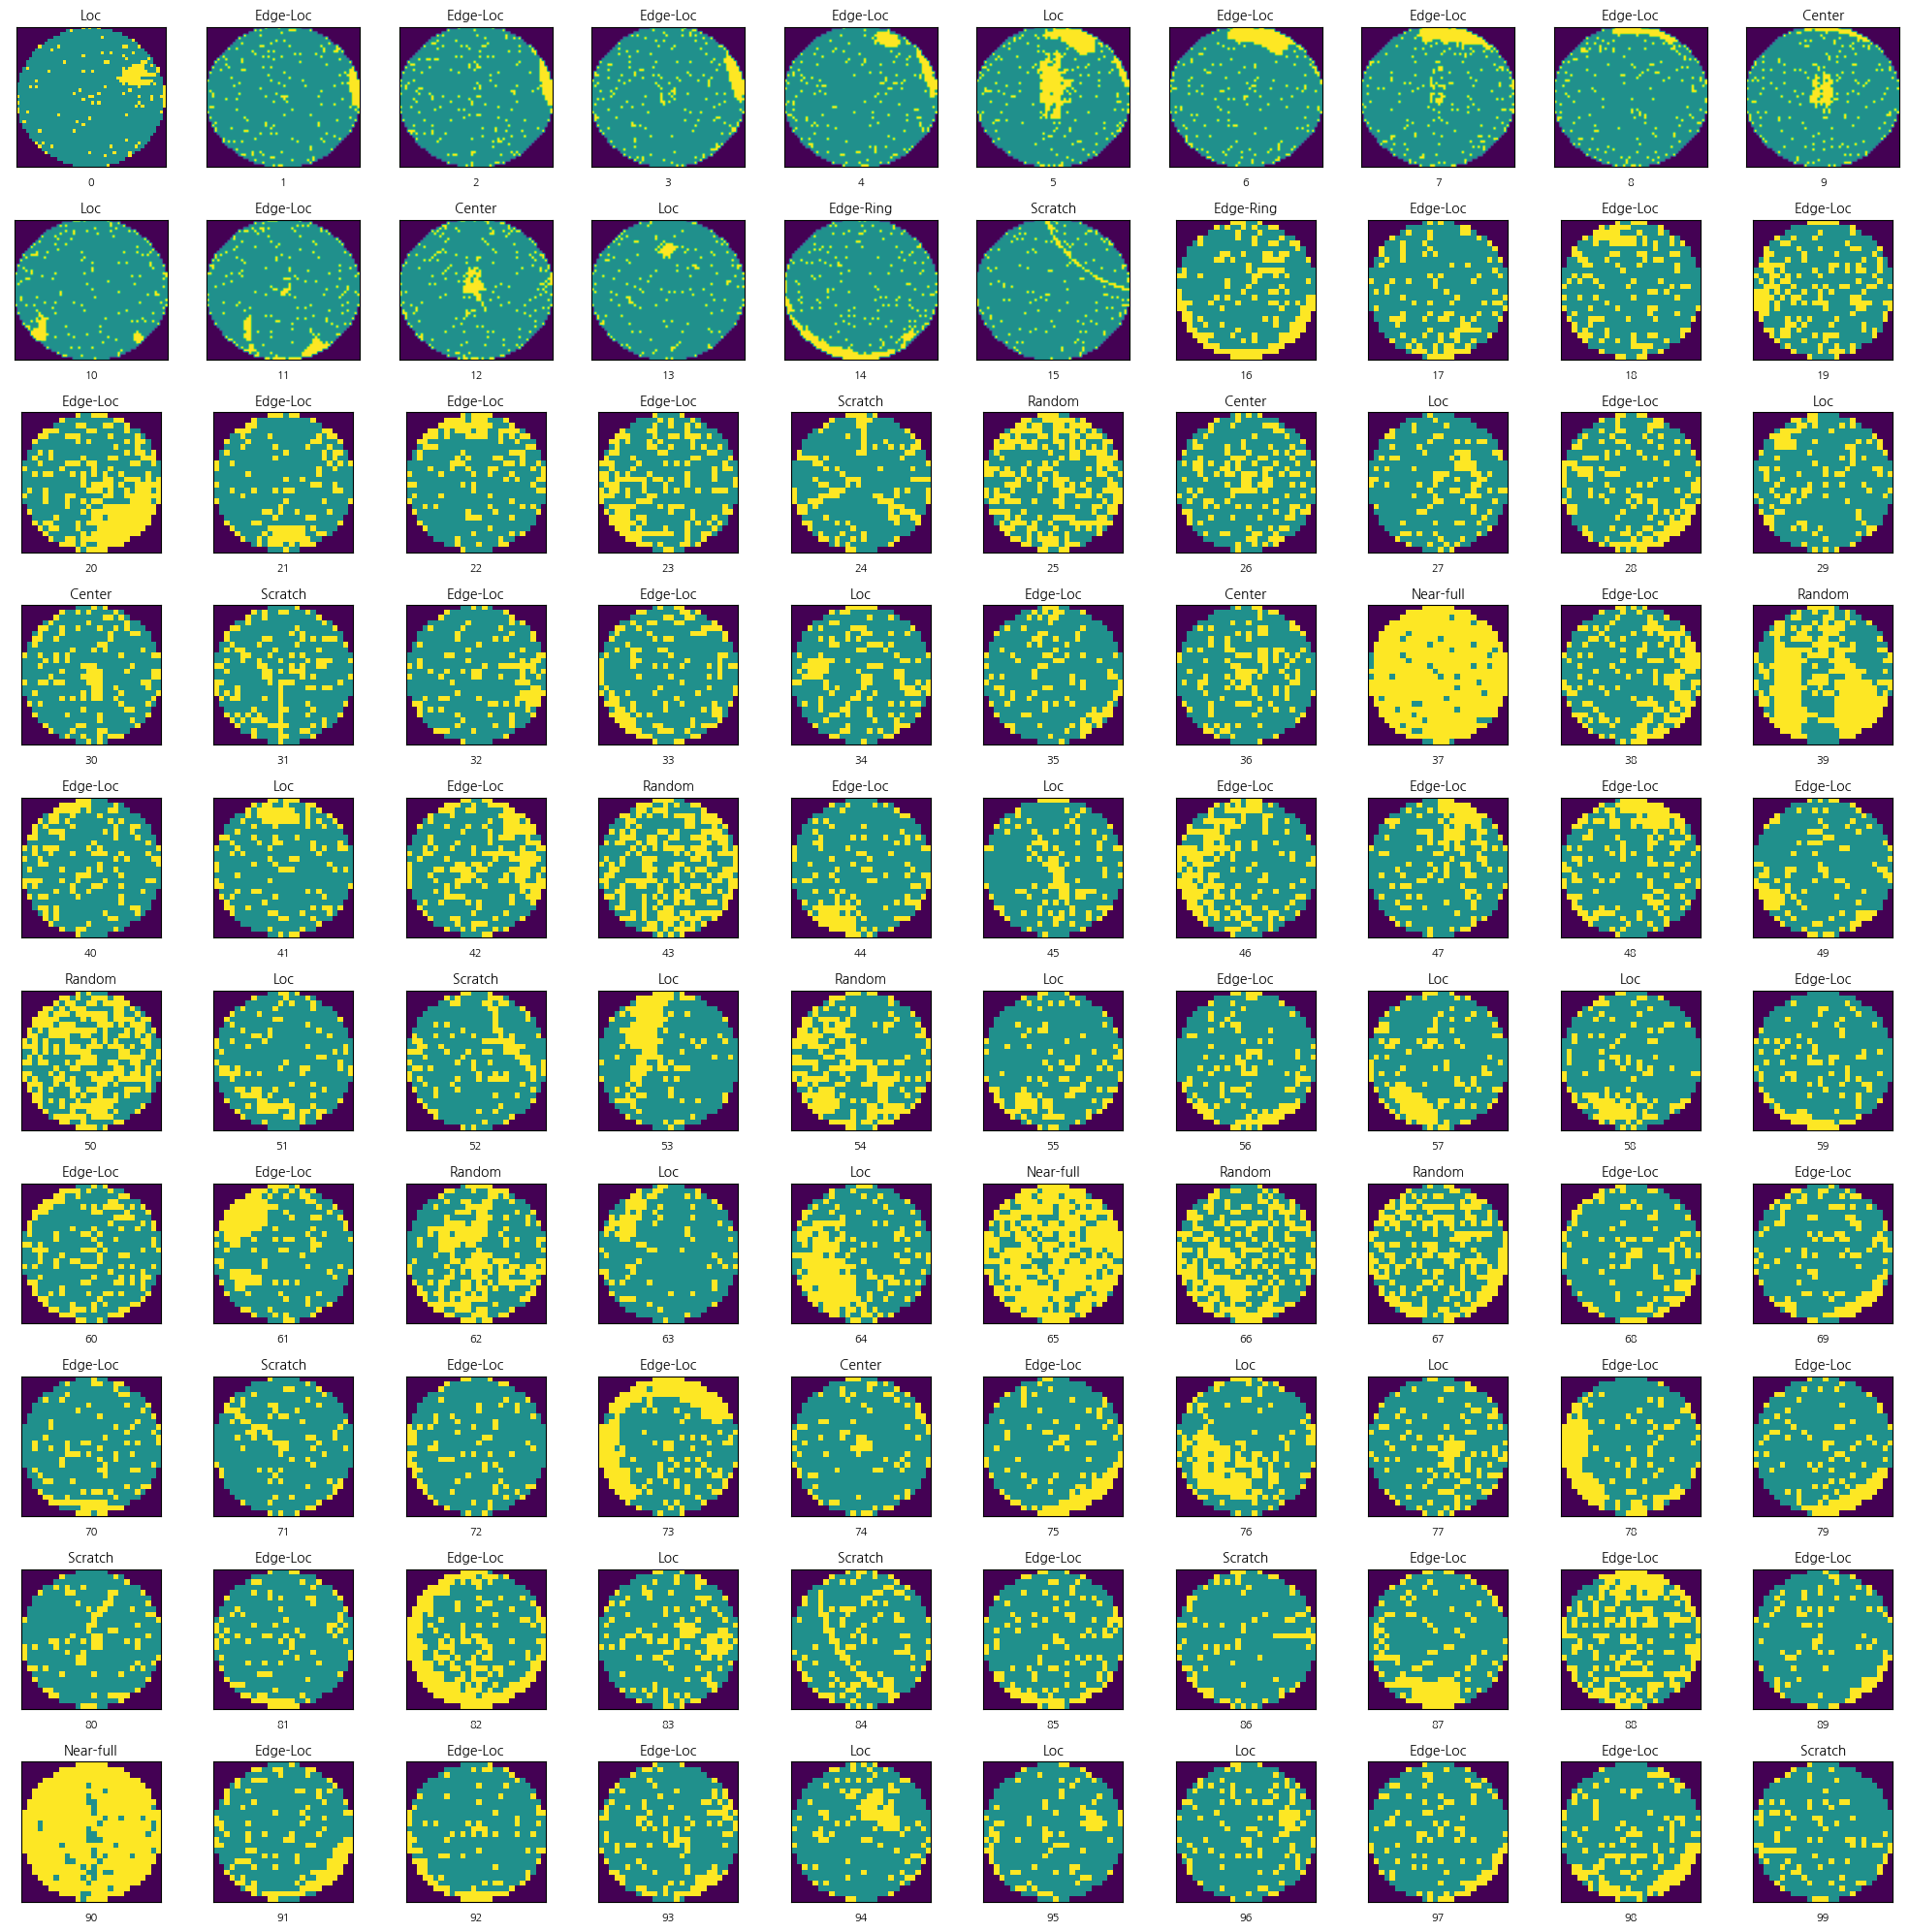

In [15]:
#불량 종류 시각화 - 2
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_label_values.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_label_values.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_label_values.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

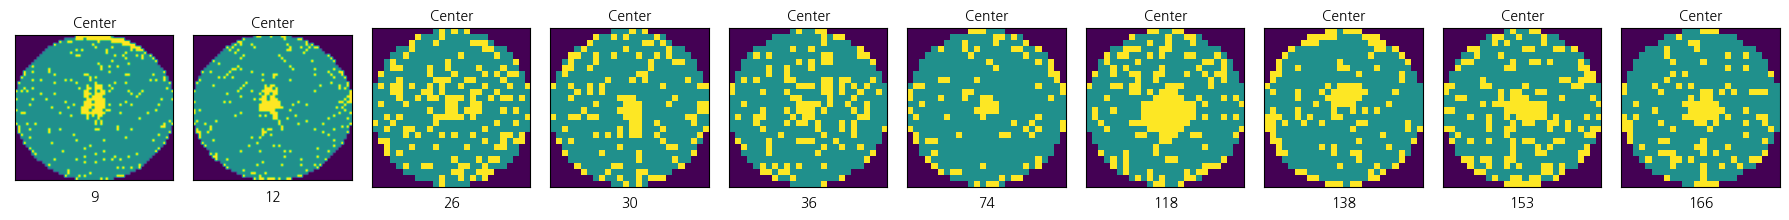

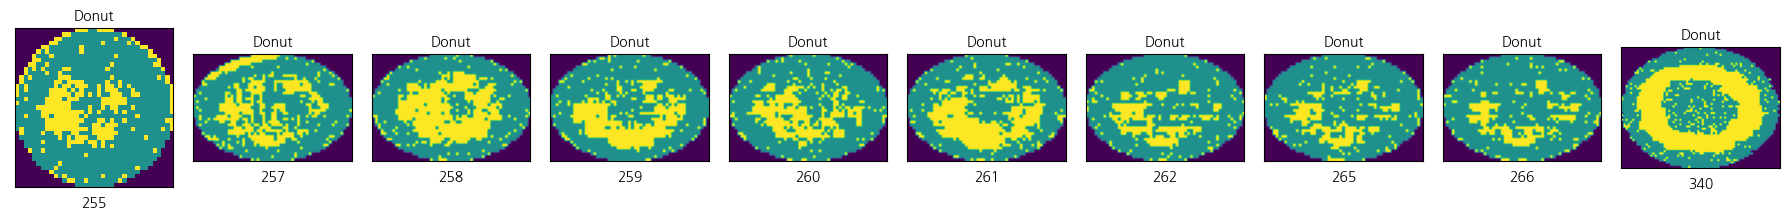

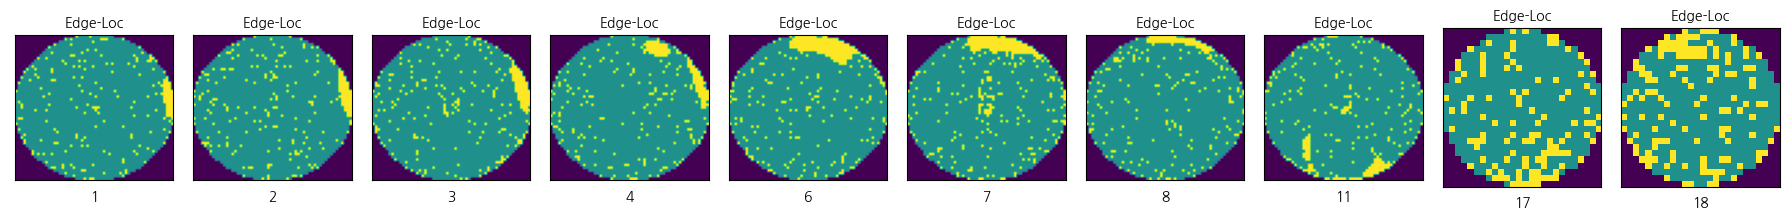

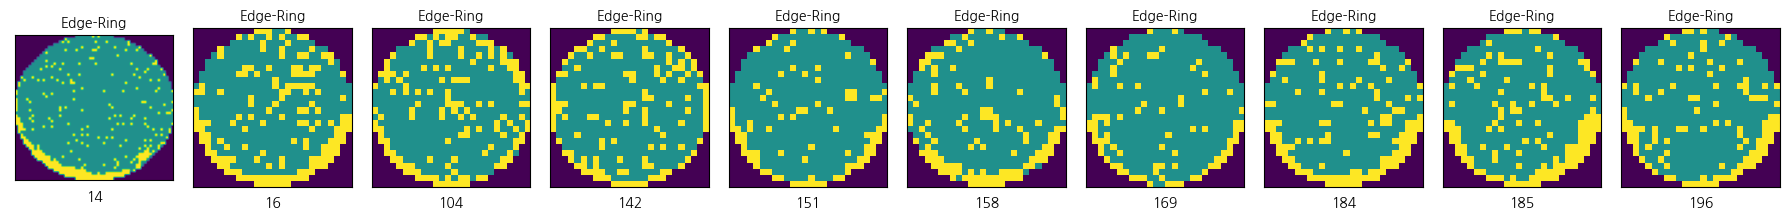

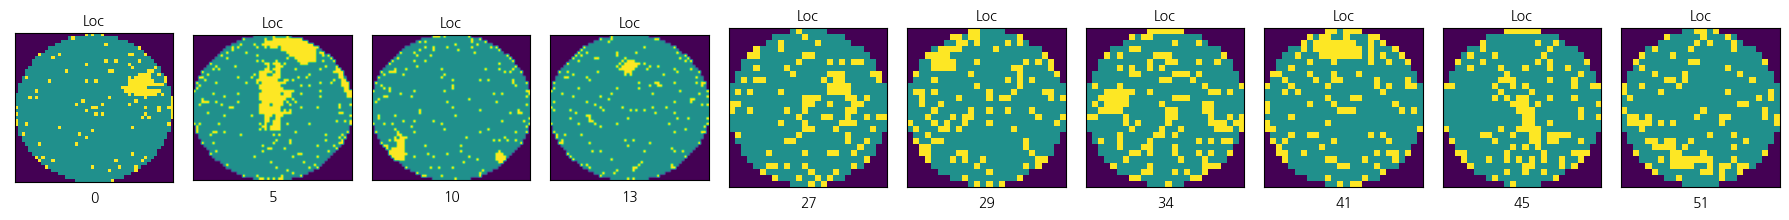

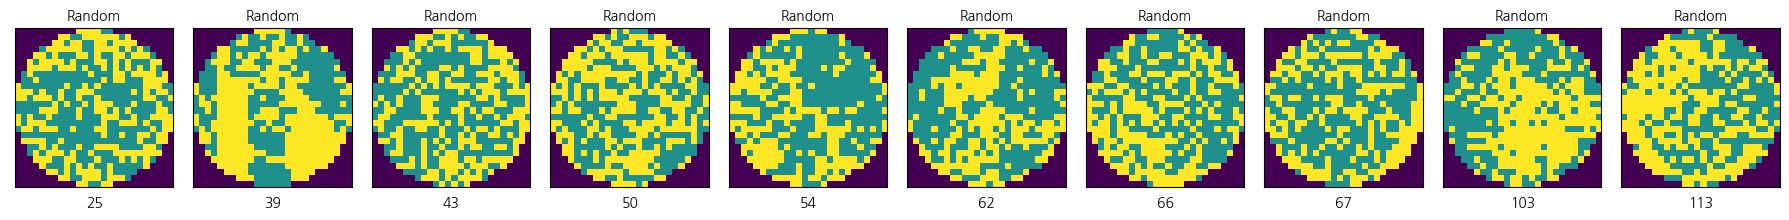

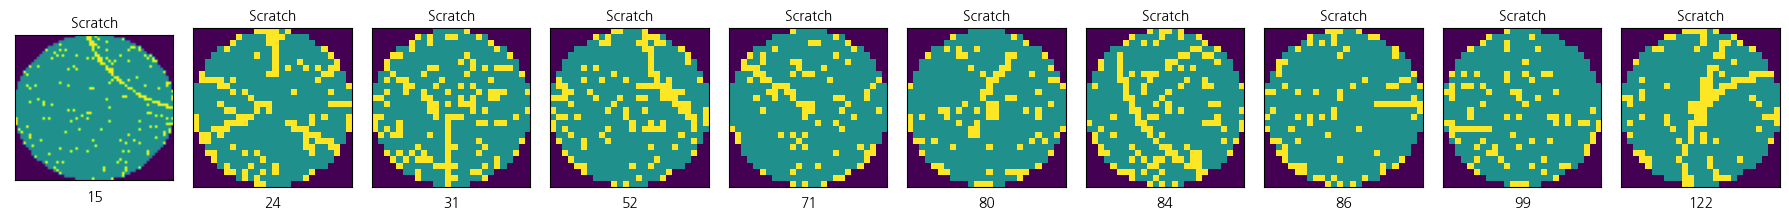

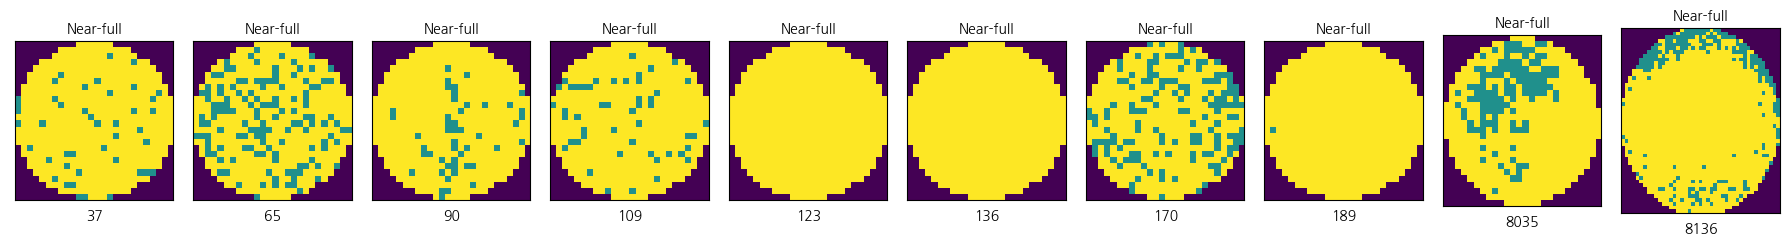

In [16]:
#불량 종류 시각화 - 3
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_label_values.waferMap[df_label_values.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_label_values.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_label_values.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [17]:
df_wafermap.groupby('failureType')['failureType'].count()

failureType
Center         4294
Donut           555
Edge-Loc       5189
Edge-Ring      9680
Loc            3593
Near-full       149
Random          866
Scratch        1193
none         147431
Name: failureType, dtype: int64

In [18]:
#모델 구조를 좀더 자세히 보기위한 커스텀 Fuction
def custom_summary(model):
    print("Model: {}".format(model.name))
    print("Layers:")
    
    input_shape = model.layers[0].input_shape
    for i, layer in enumerate(model.layers):
        config = layer.get_config()
        output_shape = layer.output_shape
        
        layer_info = "  Layer {}: {} |".format(i, layer.__class__.__name__)
        
        if 'filters' in config:
            layer_info += " Filters: {} |".format(config['filters'])
        if 'kernel_size' in config:
            layer_info += " Filter size: {}x{} |".format(config['kernel_size'][0], config['kernel_size'][1])
        if 'padding' in config:
            layer_info += " Padding: {} |".format(config['padding'])
        if 'activation' in config:
            layer_info += " Activation: {} |".format(config['activation'])
            
        if isinstance(output_shape, list):
            output_shape = output_shape[0]
        
        layer_info += " Output shape: {}".format(output_shape)
        print(layer_info)
        
        input_shape = output_shape

In [19]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="wafermap_train",

    # track hyperparameters and run metadata with wandb.config
    config={
        "learning_rate": 0.001,
        "epoch": 100,
        "batch_size": 100
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hyunwoojang86 (euclidsoft). Use `wandb login --relogin` to force relogin


In [20]:
#전체 9가지 라벨 리스트
wf_train_labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full', 'none']
model = keras.applications.MobileNetV2(classes=len(wf_train_labels), weights=None)
model.compile(optimizer=Adam(learning_rate=config.learning_rate)
              , loss='categorical_crossentropy'
              , metrics=['accuracy'
                         , tf.keras.metrics.Recall()
                         , tf.keras.metrics.Precision()
                        , tensorflow_addons.metrics.F1Score(num_classes=len(wf_train_labels), average='macro')
                        ])
custom_summary(model)

Model: mobilenetv2_1.00_224
Layers:
  Layer 0: InputLayer | Output shape: (None, 224, 224, 3)
  Layer 1: Conv2D | Filters: 32 | Filter size: 3x3 | Padding: same | Activation: linear | Output shape: (None, 112, 112, 32)
  Layer 2: BatchNormalization | Output shape: (None, 112, 112, 32)
  Layer 3: ReLU | Output shape: (None, 112, 112, 32)
  Layer 4: DepthwiseConv2D | Filter size: 3x3 | Padding: same | Activation: linear | Output shape: (None, 112, 112, 32)
  Layer 5: BatchNormalization | Output shape: (None, 112, 112, 32)
  Layer 6: ReLU | Output shape: (None, 112, 112, 32)
  Layer 7: Conv2D | Filters: 16 | Filter size: 1x1 | Padding: same | Activation: linear | Output shape: (None, 112, 112, 16)
  Layer 8: BatchNormalization | Output shape: (None, 112, 112, 16)
  Layer 9: Conv2D | Filters: 96 | Filter size: 1x1 | Padding: same | Activation: linear | Output shape: (None, 112, 112, 96)
  Layer 10: BatchNormalization | Output shape: (None, 112, 112, 96)
  Layer 11: ReLU | Output shape: (No

In [21]:
#불량 이미지 저장을 위한 폴더 생성
for f_labels in wf_train_labels:
    if not os.path.exists(os.path.join('wafermap_images', f_labels)):
        os.makedirs(os.path.join('wafermap_images', f_labels))

In [22]:
#이미지 추출 및 파일 저장 함수
def image_write(rows):
    write_path = os.path.join('wafermap_images', rows['failureType'], str(int(rows['index'])) + '.png')
    wafermap_rgb = np.zeros((rows['waferMap'].shape[0], rows['waferMap'].shape[1], 3), dtype=np.uint8)
    for i in range(rows['waferMap'].shape[0]):
        for j in range(rows['waferMap'].shape[1]):
            # wafermap의 각 값에 대한 RGB 색상 코드를 설정합니다.
            if rows['waferMap'][i, j] == 0:
                wafermap_rgb[i, j] = [82, 1, 74]  # 검정색 (배경)
            elif rows['waferMap'][i, j] == 1:
                wafermap_rgb[i, j] = [37, 231, 255]  # 노란색 (양품)
            else:
                wafermap_rgb[i, j] = [150, 144, 28]  # 초록색 (불량)
    cv2.cvtColor(wafermap_rgb, cv2.COLOR_BGR2RGB)
    cv2.imwrite(write_path, wafermap_rgb)

In [23]:
#이미지 추출 및 이미지 객체 리턴 함수
def image_return_wafermap(waferMap):
    wafermap_rgb = np.zeros((waferMap.shape[0], waferMap.shape[1], 3), dtype=np.uint8)
    for i in range(waferMap.shape[0]):
        for j in range(waferMap.shape[1]):
            # wafermap의 각 값에 대한 RGB 색상 코드를 설정합니다.
            if waferMap[i, j] == 0:
                wafermap_rgb[i, j] = [82, 1, 74]  # 검정색 (배경)
            elif waferMap[i, j] == 1:
                wafermap_rgb[i, j] = [37, 231, 255]  # 노란색 (양품)
            else:
                wafermap_rgb[i, j] = [150, 144, 28]  # 초록색 (불량)
    return wafermap_rgb

In [24]:
#최초 실행시 이미지 저장 실행(멀티 프로세싱 적용)
if is_first:
    df_wafermap.mapply(lambda x: image_write(x), axis=1)

In [25]:
#증량 작업을 위한 ImageDataGenerator 초기화
image_data_generator = ImageDataGenerator(
    rotation_range=10,           # 0~10°의 무작위 회전
    width_shift_range=0.2,       # 너비 이동 (0~1 사이의 비율)
    height_shift_range=0.2,      # 높이 이동 (0~1 사이의 비율)
    shear_range=0.15,             # 전단 변환 적용 범위 (0~1 사이의 비율)
    zoom_range=0.1,              # 확대/축소 범위 (1±zoom_range)
    horizontal_flip=True,        # 좌우 대칭 적용
    channel_shift_range=0.1,     # 채널 값 이동 범위 (0~1 사이의 비율)
    fill_mode='nearest'          # 이미지 외부 영역의 픽셀을 어떻게 채울지 결정 ('nearest', 'constant', 'reflect', 'wrap')
)

In [26]:
#증량 작업을 위한 코드
wf_labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
if is_first:
    for l in wf_labels:
        wafer_label_images = df_wafermap[df_wafermap['failureType'] == l]
        wafer_label_images = wafer_label_images.reset_index()
        aug_count = 10000 - len(wafer_label_images)
        print(l)
        for i in tqdm(range(aug_count)):
            random_idx = random.randint(0, len(wafer_label_images) - 1)
            wafer_image = image_return_wafermap(wafer_label_images.iloc[random_idx].waferMap)
            wafer_image = np.expand_dims(wafer_image, 0)
            g = image_data_generator.flow(wafer_image, batch_size=1)
            aug_image = next(g)
            write_path = os.path.join('wafermap_images', l, str(int(i)) + '_augmentation.png')
            if not os.path.exists(os.path.join('wafermap_images', l)):
                os.makedirs(os.path.join('wafermap_images', l))
            cv2.imwrite(write_path, aug_image[0])

In [27]:
none_size = 10000

In [28]:
#각 라벨링별 1만건 추출 작업
all_train_images = []
for idx, l in enumerate(wf_train_labels):
    image_directory = os.path.join('wafermap_images', l)
    ims = [(os.path.join(image_directory, f), idx) for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]
    random.shuffle(ims)
    if l == 'none':
        ims = ims[:none_size]
    all_train_images.extend(ims)

In [29]:
pd.DataFrame(all_train_images, columns=['image_path', 'failureType']).groupby('failureType').count()

,image_path
failureType,
0,10000
1,10000
2,10000
3,10000
4,10000
5,10000
6,10000
7,10000
8,10000


In [30]:
#train, val, test 데이터셋 추출(65 : 20 : 10)
train_files, test_files = train_test_split(all_train_images, test_size=0.35, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.42, random_state=42)

In [31]:
print('train_data : ', len(train_files)
      , '\nvalidation_data : ', len(val_files)
      , '\ntest_data : ', len(test_files))

train_data :  58500 
validation_data :  18270 
test_data :  13230


In [32]:
#모델 선언시 언급한 문제로 입력 사이즈 112*112에 따라 이미지 리사즈하여 로드 처리
dsize = 224
def load_images_and_labels(files_list):
    images, labels = [], []
    for file, label in tqdm(files_list):
        img = cv2.imread(file)
        img = cv2.resize(img, (dsize, dsize))
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

In [33]:
#학습 데이터 로드
train_images, train_labels = load_images_and_labels(train_files)
val_images, val_labels = load_images_and_labels(val_files)
test_images, test_labels = load_images_and_labels(test_files)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13230/13230 [00:00<00:00, 15451.99it/s]


In [34]:
#라벨링 데이터 차원 변경
train_labels = to_categorical(train_labels, len(wf_train_labels))
val_labels = to_categorical(val_labels, len(wf_train_labels))
test_labels = to_categorical(test_labels, len(wf_train_labels))

In [35]:
with tf.device('CPU'):
    #데이터 메모리 선 적재를 위한 텐서 변경 및 분할 작업
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

2023-04-21 12:42:11.186166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8805888000 exceeds 10% of free system memory.


In [36]:
batch_size = 50  #배치크기
buffer_size = 10000  # 버퍼크기
epochs = 100 #에폭
steps_per_epoch = len(train_images) // batch_size  # steps_per_epoch 계산
val_steps_per_epoch = len(val_images) // batch_size  # val_steps_per_epoch 계산

In [37]:
# 학습 데이터를 섞어 미리 메모리 적재(빠른 로딩을 위한 동적로드 적용)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [38]:
# 검증 데이터를 섞어 미리 메모리 적재(빠른 로딩을 위한 동적로드 적용)
validation_dataset = validation_dataset.shuffle(buffer_size).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [39]:
#학습 진행
model_fit_history = None
model_fit_history = model.fit(train_dataset
                              , validation_data=validation_dataset
                              , validation_steps=val_steps_per_epoch
                              , epochs=epochs
                              , steps_per_epoch=steps_per_epoch
                             , callbacks=[WandbMetricsLogger(log_freq=5),
                                      WandbModelCheckpoint("models")
                                    ])

2023-04-21 12:42:14.050143: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8805888000 exceeds 10% of free system memory.


Epoch 1/100
1170/1170 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.7865 - recall: 0.7293 - precision: 0.8524 - f1_score: 0.7825

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1170/1170 [==============================] - 252s 212ms/step - loss: 0.5960 - accuracy: 0.7865 - recall: 0.7293 - precision: 0.8524 - f1_score: 0.7825 - val_loss: 8.9473 - val_accuracy: 0.1061 - val_recall: 0.1061 - val_precision: 0.1061 - val_f1_score: 0.0213
Epoch 2/100
1170/1170 [==============================] - ETA: 0s - loss: 0.3440 - accuracy: 0.8772 - recall: 0.8563 - precision: 0.9000 - f1_score: 0.8759

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 212ms/step - loss: 0.3440 - accuracy: 0.8772 - recall: 0.8563 - precision: 0.9000 - f1_score: 0.8759 - val_loss: 13.3059 - val_accuracy: 0.1061 - val_recall: 0.1061 - val_precision: 0.1061 - val_f1_score: 0.0213
Epoch 3/100
1170/1170 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8941 - recall: 0.8768 - precision: 0.9124 - f1_score: 0.8932

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.2945 - accuracy: 0.8941 - recall: 0.8768 - precision: 0.9124 - f1_score: 0.8932 - val_loss: 10.5379 - val_accuracy: 0.1062 - val_recall: 0.1062 - val_precision: 0.1062 - val_f1_score: 0.0213
Epoch 4/100
1170/1170 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9102 - recall: 0.8970 - precision: 0.9258 - f1_score: 0.9096

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.2527 - accuracy: 0.9102 - recall: 0.8970 - precision: 0.9258 - f1_score: 0.9096 - val_loss: 2.5791 - val_accuracy: 0.6583 - val_recall: 0.6505 - val_precision: 0.6755 - val_f1_score: 0.6407
Epoch 5/100
1170/1170 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9159 - recall: 0.9043 - precision: 0.9288 - f1_score: 0.9153

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.2315 - accuracy: 0.9159 - recall: 0.9043 - precision: 0.9288 - f1_score: 0.9153 - val_loss: 6.0839 - val_accuracy: 0.5824 - val_recall: 0.5786 - val_precision: 0.5909 - val_f1_score: 0.5152
Epoch 6/100
1170/1170 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9220 - recall: 0.9118 - precision: 0.9331 - f1_score: 0.9215

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.2149 - accuracy: 0.9220 - recall: 0.9118 - precision: 0.9331 - f1_score: 0.9215 - val_loss: 3.4590 - val_accuracy: 0.6250 - val_recall: 0.6215 - val_precision: 0.6300 - val_f1_score: 0.5923
Epoch 7/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9300 - recall: 0.9210 - precision: 0.9401 - f1_score: 0.9296

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.1929 - accuracy: 0.9300 - recall: 0.9210 - precision: 0.9401 - f1_score: 0.9296 - val_loss: 4.7425 - val_accuracy: 0.5978 - val_recall: 0.5950 - val_precision: 0.6031 - val_f1_score: 0.5644
Epoch 8/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9366 - recall: 0.9283 - precision: 0.9452 - f1_score: 0.9364

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.1756 - accuracy: 0.9366 - recall: 0.9283 - precision: 0.9452 - f1_score: 0.9364 - val_loss: 2.8584 - val_accuracy: 0.6910 - val_recall: 0.6887 - val_precision: 0.6954 - val_f1_score: 0.6490
Epoch 9/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9410 - recall: 0.9341 - precision: 0.9484 - f1_score: 0.9408

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.1642 - accuracy: 0.9410 - recall: 0.9341 - precision: 0.9484 - f1_score: 0.9408 - val_loss: 2.5041 - val_accuracy: 0.7116 - val_recall: 0.7063 - val_precision: 0.7177 - val_f1_score: 0.7115
Epoch 10/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9459 - recall: 0.9401 - precision: 0.9536 - f1_score: 0.9457

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.1469 - accuracy: 0.9459 - recall: 0.9401 - precision: 0.9536 - f1_score: 0.9457 - val_loss: 1.9677 - val_accuracy: 0.7161 - val_recall: 0.7083 - val_precision: 0.7246 - val_f1_score: 0.7200
Epoch 11/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9520 - recall: 0.9464 - precision: 0.9583 - f1_score: 0.9518

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.1339 - accuracy: 0.9520 - recall: 0.9464 - precision: 0.9583 - f1_score: 0.9518 - val_loss: 1.9271 - val_accuracy: 0.7539 - val_recall: 0.7488 - val_precision: 0.7617 - val_f1_score: 0.7437
Epoch 12/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9556 - recall: 0.9508 - precision: 0.9608 - f1_score: 0.9554

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.1225 - accuracy: 0.9556 - recall: 0.9508 - precision: 0.9608 - f1_score: 0.9554 - val_loss: 1.0397 - val_accuracy: 0.7905 - val_recall: 0.7827 - val_precision: 0.7989 - val_f1_score: 0.7876
Epoch 13/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9594 - recall: 0.9556 - precision: 0.9643 - f1_score: 0.9593

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 214ms/step - loss: 0.1109 - accuracy: 0.9594 - recall: 0.9556 - precision: 0.9643 - f1_score: 0.9593 - val_loss: 0.7830 - val_accuracy: 0.8461 - val_recall: 0.8426 - val_precision: 0.8506 - val_f1_score: 0.8491
Epoch 14/100
1170/1170 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9627 - recall: 0.9591 - precision: 0.9669 - f1_score: 0.9627

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 253s 216ms/step - loss: 0.1015 - accuracy: 0.9627 - recall: 0.9591 - precision: 0.9669 - f1_score: 0.9627 - val_loss: 1.7975 - val_accuracy: 0.7496 - val_recall: 0.7460 - val_precision: 0.7559 - val_f1_score: 0.7461
Epoch 15/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9666 - recall: 0.9633 - precision: 0.9702 - f1_score: 0.9666

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0907 - accuracy: 0.9666 - recall: 0.9633 - precision: 0.9702 - f1_score: 0.9666 - val_loss: 0.9238 - val_accuracy: 0.8150 - val_recall: 0.8094 - val_precision: 0.8241 - val_f1_score: 0.8144
Epoch 16/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9698 - recall: 0.9670 - precision: 0.9730 - f1_score: 0.9697

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0834 - accuracy: 0.9698 - recall: 0.9670 - precision: 0.9730 - f1_score: 0.9697 - val_loss: 0.7414 - val_accuracy: 0.8596 - val_recall: 0.8565 - val_precision: 0.8634 - val_f1_score: 0.8613
Epoch 17/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9718 - recall: 0.9691 - precision: 0.9747 - f1_score: 0.9718

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0773 - accuracy: 0.9718 - recall: 0.9691 - precision: 0.9747 - f1_score: 0.9718 - val_loss: 0.7561 - val_accuracy: 0.8553 - val_recall: 0.8517 - val_precision: 0.8612 - val_f1_score: 0.8559
Epoch 18/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9734 - recall: 0.9710 - precision: 0.9761 - f1_score: 0.9734

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0721 - accuracy: 0.9734 - recall: 0.9710 - precision: 0.9761 - f1_score: 0.9734 - val_loss: 0.7853 - val_accuracy: 0.8405 - val_recall: 0.8367 - val_precision: 0.8457 - val_f1_score: 0.8421
Epoch 19/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9762 - recall: 0.9744 - precision: 0.9784 - f1_score: 0.9762

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.0648 - accuracy: 0.9762 - recall: 0.9744 - precision: 0.9784 - f1_score: 0.9762 - val_loss: 0.4762 - val_accuracy: 0.8985 - val_recall: 0.8948 - val_precision: 0.9023 - val_f1_score: 0.8984
Epoch 20/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9779 - recall: 0.9759 - precision: 0.9802 - f1_score: 0.9779

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0621 - accuracy: 0.9779 - recall: 0.9759 - precision: 0.9802 - f1_score: 0.9779 - val_loss: 0.6778 - val_accuracy: 0.8695 - val_recall: 0.8673 - val_precision: 0.8729 - val_f1_score: 0.8729
Epoch 21/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9783 - recall: 0.9766 - precision: 0.9803 - f1_score: 0.9783

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0589 - accuracy: 0.9783 - recall: 0.9766 - precision: 0.9803 - f1_score: 0.9783 - val_loss: 0.5929 - val_accuracy: 0.8860 - val_recall: 0.8837 - val_precision: 0.8890 - val_f1_score: 0.8875
Epoch 22/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9814 - recall: 0.9800 - precision: 0.9829 - f1_score: 0.9814

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0515 - accuracy: 0.9814 - recall: 0.9800 - precision: 0.9829 - f1_score: 0.9814 - val_loss: 0.6499 - val_accuracy: 0.8814 - val_recall: 0.8801 - val_precision: 0.8830 - val_f1_score: 0.8839
Epoch 23/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9806 - recall: 0.9793 - precision: 0.9822 - f1_score: 0.9806

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 253s 216ms/step - loss: 0.0552 - accuracy: 0.9806 - recall: 0.9793 - precision: 0.9822 - f1_score: 0.9806 - val_loss: 0.5424 - val_accuracy: 0.8878 - val_recall: 0.8861 - val_precision: 0.8906 - val_f1_score: 0.8909
Epoch 24/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9827 - recall: 0.9816 - precision: 0.9841 - f1_score: 0.9827

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.0477 - accuracy: 0.9827 - recall: 0.9816 - precision: 0.9841 - f1_score: 0.9827 - val_loss: 0.4560 - val_accuracy: 0.9062 - val_recall: 0.9050 - val_precision: 0.9093 - val_f1_score: 0.9081
Epoch 25/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9834 - recall: 0.9821 - precision: 0.9846 - f1_score: 0.9834

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0458 - accuracy: 0.9834 - recall: 0.9821 - precision: 0.9846 - f1_score: 0.9834 - val_loss: 0.6077 - val_accuracy: 0.8923 - val_recall: 0.8905 - val_precision: 0.8952 - val_f1_score: 0.8926
Epoch 26/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9852 - recall: 0.9841 - precision: 0.9864 - f1_score: 0.9852

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 216ms/step - loss: 0.0424 - accuracy: 0.9852 - recall: 0.9841 - precision: 0.9864 - f1_score: 0.9852 - val_loss: 1.0047 - val_accuracy: 0.8547 - val_recall: 0.8531 - val_precision: 0.8564 - val_f1_score: 0.8570
Epoch 27/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9858 - recall: 0.9847 - precision: 0.9869 - f1_score: 0.9858

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0397 - accuracy: 0.9858 - recall: 0.9847 - precision: 0.9869 - f1_score: 0.9858 - val_loss: 0.6529 - val_accuracy: 0.8842 - val_recall: 0.8824 - val_precision: 0.8860 - val_f1_score: 0.8870
Epoch 28/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9850 - recall: 0.9840 - precision: 0.9860 - f1_score: 0.9850

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 253s 216ms/step - loss: 0.0440 - accuracy: 0.9850 - recall: 0.9840 - precision: 0.9860 - f1_score: 0.9850 - val_loss: 0.4655 - val_accuracy: 0.9114 - val_recall: 0.9098 - val_precision: 0.9130 - val_f1_score: 0.9112
Epoch 29/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9860 - recall: 0.9854 - precision: 0.9867 - f1_score: 0.9860

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0390 - accuracy: 0.9860 - recall: 0.9854 - precision: 0.9867 - f1_score: 0.9860 - val_loss: 0.9233 - val_accuracy: 0.8406 - val_recall: 0.8380 - val_precision: 0.8453 - val_f1_score: 0.8409
Epoch 30/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9871 - recall: 0.9865 - precision: 0.9880 - f1_score: 0.9871

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.0359 - accuracy: 0.9871 - recall: 0.9865 - precision: 0.9880 - f1_score: 0.9871 - val_loss: 0.4171 - val_accuracy: 0.9128 - val_recall: 0.9114 - val_precision: 0.9148 - val_f1_score: 0.9146
Epoch 31/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9883 - recall: 0.9877 - precision: 0.9889 - f1_score: 0.9883

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0326 - accuracy: 0.9883 - recall: 0.9877 - precision: 0.9889 - f1_score: 0.9883 - val_loss: 0.5775 - val_accuracy: 0.8930 - val_recall: 0.8920 - val_precision: 0.8949 - val_f1_score: 0.8950
Epoch 32/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9879 - recall: 0.9872 - precision: 0.9887 - f1_score: 0.9879

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0351 - accuracy: 0.9879 - recall: 0.9872 - precision: 0.9887 - f1_score: 0.9879 - val_loss: 0.4924 - val_accuracy: 0.9059 - val_recall: 0.9039 - val_precision: 0.9088 - val_f1_score: 0.9081
Epoch 33/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9874 - recall: 0.9867 - precision: 0.9882 - f1_score: 0.9873

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0339 - accuracy: 0.9874 - recall: 0.9867 - precision: 0.9882 - f1_score: 0.9873 - val_loss: 0.4755 - val_accuracy: 0.9080 - val_recall: 0.9069 - val_precision: 0.9098 - val_f1_score: 0.9086
Epoch 34/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9894 - recall: 0.9888 - precision: 0.9899 - f1_score: 0.9894

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0300 - accuracy: 0.9894 - recall: 0.9888 - precision: 0.9899 - f1_score: 0.9894 - val_loss: 0.4440 - val_accuracy: 0.9176 - val_recall: 0.9167 - val_precision: 0.9196 - val_f1_score: 0.9172
Epoch 35/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9901 - recall: 0.9897 - precision: 0.9906 - f1_score: 0.9901

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0302 - accuracy: 0.9901 - recall: 0.9897 - precision: 0.9906 - f1_score: 0.9901 - val_loss: 0.3940 - val_accuracy: 0.9243 - val_recall: 0.9235 - val_precision: 0.9257 - val_f1_score: 0.9249
Epoch 36/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9891 - recall: 0.9884 - precision: 0.9896 - f1_score: 0.9891

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0325 - accuracy: 0.9891 - recall: 0.9884 - precision: 0.9896 - f1_score: 0.9891 - val_loss: 0.4347 - val_accuracy: 0.9065 - val_recall: 0.9049 - val_precision: 0.9092 - val_f1_score: 0.9079
Epoch 37/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9900 - recall: 0.9896 - precision: 0.9904 - f1_score: 0.9900

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0287 - accuracy: 0.9900 - recall: 0.9896 - precision: 0.9904 - f1_score: 0.9900 - val_loss: 0.6847 - val_accuracy: 0.8924 - val_recall: 0.8911 - val_precision: 0.8947 - val_f1_score: 0.8924
Epoch 38/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9907 - recall: 0.9904 - precision: 0.9912 - f1_score: 0.9907

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0267 - accuracy: 0.9907 - recall: 0.9904 - precision: 0.9912 - f1_score: 0.9907 - val_loss: 0.4430 - val_accuracy: 0.9132 - val_recall: 0.9121 - val_precision: 0.9152 - val_f1_score: 0.9139
Epoch 39/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9904 - recall: 0.9900 - precision: 0.9908 - f1_score: 0.9904

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.0277 - accuracy: 0.9904 - recall: 0.9900 - precision: 0.9908 - f1_score: 0.9904 - val_loss: 0.6336 - val_accuracy: 0.8955 - val_recall: 0.8945 - val_precision: 0.8968 - val_f1_score: 0.8977
Epoch 40/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9914 - recall: 0.9910 - precision: 0.9918 - f1_score: 0.9914

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0257 - accuracy: 0.9914 - recall: 0.9910 - precision: 0.9918 - f1_score: 0.9914 - val_loss: 0.5581 - val_accuracy: 0.9008 - val_recall: 0.8996 - val_precision: 0.9039 - val_f1_score: 0.9022
Epoch 41/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9911 - recall: 0.9908 - precision: 0.9916 - f1_score: 0.9912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0256 - accuracy: 0.9911 - recall: 0.9908 - precision: 0.9916 - f1_score: 0.9912 - val_loss: 0.5218 - val_accuracy: 0.9074 - val_recall: 0.9059 - val_precision: 0.9096 - val_f1_score: 0.9066
Epoch 42/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9907 - recall: 0.9905 - precision: 0.9911 - f1_score: 0.9907

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0267 - accuracy: 0.9907 - recall: 0.9905 - precision: 0.9911 - f1_score: 0.9907 - val_loss: 0.3334 - val_accuracy: 0.9305 - val_recall: 0.9292 - val_precision: 0.9323 - val_f1_score: 0.9302
Epoch 43/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9917 - recall: 0.9913 - precision: 0.9920 - f1_score: 0.9917

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 253s 216ms/step - loss: 0.0241 - accuracy: 0.9917 - recall: 0.9913 - precision: 0.9920 - f1_score: 0.9917 - val_loss: 0.9614 - val_accuracy: 0.8368 - val_recall: 0.8345 - val_precision: 0.8423 - val_f1_score: 0.8369
Epoch 44/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9923 - recall: 0.9921 - precision: 0.9926 - f1_score: 0.9923

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0218 - accuracy: 0.9923 - recall: 0.9921 - precision: 0.9926 - f1_score: 0.9923 - val_loss: 0.3717 - val_accuracy: 0.9291 - val_recall: 0.9282 - val_precision: 0.9315 - val_f1_score: 0.9291
Epoch 45/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9921 - recall: 0.9920 - precision: 0.9924 - f1_score: 0.9921

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0230 - accuracy: 0.9921 - recall: 0.9920 - precision: 0.9924 - f1_score: 0.9921 - val_loss: 0.4558 - val_accuracy: 0.9170 - val_recall: 0.9152 - val_precision: 0.9188 - val_f1_score: 0.9154
Epoch 46/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9923 - recall: 0.9920 - precision: 0.9926 - f1_score: 0.9923

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0226 - accuracy: 0.9923 - recall: 0.9920 - precision: 0.9926 - f1_score: 0.9923 - val_loss: 0.3959 - val_accuracy: 0.9262 - val_recall: 0.9253 - val_precision: 0.9278 - val_f1_score: 0.9264
Epoch 47/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9913 - recall: 0.9911 - precision: 0.9918 - f1_score: 0.9913

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0249 - accuracy: 0.9913 - recall: 0.9911 - precision: 0.9918 - f1_score: 0.9913 - val_loss: 0.5378 - val_accuracy: 0.9049 - val_recall: 0.9033 - val_precision: 0.9066 - val_f1_score: 0.9068
Epoch 48/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9940 - recall: 0.9938 - precision: 0.9942 - f1_score: 0.9940

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0185 - accuracy: 0.9940 - recall: 0.9938 - precision: 0.9942 - f1_score: 0.9940 - val_loss: 0.3784 - val_accuracy: 0.9282 - val_recall: 0.9273 - val_precision: 0.9302 - val_f1_score: 0.9272
Epoch 49/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9924 - recall: 0.9921 - precision: 0.9927 - f1_score: 0.9924

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0224 - accuracy: 0.9924 - recall: 0.9921 - precision: 0.9927 - f1_score: 0.9924 - val_loss: 0.4213 - val_accuracy: 0.9281 - val_recall: 0.9275 - val_precision: 0.9285 - val_f1_score: 0.9274
Epoch 50/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9929 - recall: 0.9927 - precision: 0.9932 - f1_score: 0.9929

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 254s 217ms/step - loss: 0.0212 - accuracy: 0.9929 - recall: 0.9927 - precision: 0.9932 - f1_score: 0.9929 - val_loss: 0.9346 - val_accuracy: 0.8554 - val_recall: 0.8534 - val_precision: 0.8594 - val_f1_score: 0.8476
Epoch 51/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9937 - recall: 0.9936 - precision: 0.9939 - f1_score: 0.9937

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 255s 218ms/step - loss: 0.0185 - accuracy: 0.9937 - recall: 0.9936 - precision: 0.9939 - f1_score: 0.9937 - val_loss: 0.3780 - val_accuracy: 0.9276 - val_recall: 0.9271 - val_precision: 0.9293 - val_f1_score: 0.9279
Epoch 52/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9928 - recall: 0.9925 - precision: 0.9931 - f1_score: 0.9928

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.0209 - accuracy: 0.9928 - recall: 0.9925 - precision: 0.9931 - f1_score: 0.9928 - val_loss: 0.4463 - val_accuracy: 0.9260 - val_recall: 0.9251 - val_precision: 0.9274 - val_f1_score: 0.9253
Epoch 53/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9927 - recall: 0.9926 - precision: 0.9929 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 216ms/step - loss: 0.0207 - accuracy: 0.9927 - recall: 0.9926 - precision: 0.9929 - f1_score: 0.9927 - val_loss: 0.4805 - val_accuracy: 0.9187 - val_recall: 0.9176 - val_precision: 0.9202 - val_f1_score: 0.9195
Epoch 54/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9935 - recall: 0.9933 - precision: 0.9937 - f1_score: 0.9935

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0185 - accuracy: 0.9935 - recall: 0.9933 - precision: 0.9937 - f1_score: 0.9935 - val_loss: 0.6213 - val_accuracy: 0.9091 - val_recall: 0.9078 - val_precision: 0.9111 - val_f1_score: 0.9082
Epoch 55/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9936 - recall: 0.9935 - precision: 0.9938 - f1_score: 0.9936

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0188 - accuracy: 0.9936 - recall: 0.9935 - precision: 0.9938 - f1_score: 0.9936 - val_loss: 0.3696 - val_accuracy: 0.9281 - val_recall: 0.9276 - val_precision: 0.9302 - val_f1_score: 0.9275
Epoch 56/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9946 - recall: 0.9944 - precision: 0.9948 - f1_score: 0.9946

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0159 - accuracy: 0.9946 - recall: 0.9944 - precision: 0.9948 - f1_score: 0.9946 - val_loss: 0.3713 - val_accuracy: 0.9298 - val_recall: 0.9288 - val_precision: 0.9311 - val_f1_score: 0.9295
Epoch 57/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9928 - recall: 0.9926 - precision: 0.9930 - f1_score: 0.9928

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0202 - accuracy: 0.9928 - recall: 0.9926 - precision: 0.9930 - f1_score: 0.9928 - val_loss: 0.5354 - val_accuracy: 0.9095 - val_recall: 0.9087 - val_precision: 0.9114 - val_f1_score: 0.9100
Epoch 58/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9948 - recall: 0.9946 - precision: 0.9949 - f1_score: 0.9948

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 212ms/step - loss: 0.0163 - accuracy: 0.9948 - recall: 0.9946 - precision: 0.9949 - f1_score: 0.9948 - val_loss: 0.4183 - val_accuracy: 0.9262 - val_recall: 0.9253 - val_precision: 0.9273 - val_f1_score: 0.9268
Epoch 59/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9942 - recall: 0.9941 - precision: 0.9945 - f1_score: 0.9942

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0171 - accuracy: 0.9942 - recall: 0.9941 - precision: 0.9945 - f1_score: 0.9942 - val_loss: 0.4393 - val_accuracy: 0.9278 - val_recall: 0.9273 - val_precision: 0.9286 - val_f1_score: 0.9266
Epoch 60/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9933 - recall: 0.9931 - precision: 0.9935 - f1_score: 0.9933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.0204 - accuracy: 0.9933 - recall: 0.9931 - precision: 0.9935 - f1_score: 0.9933 - val_loss: 0.4019 - val_accuracy: 0.9316 - val_recall: 0.9308 - val_precision: 0.9331 - val_f1_score: 0.9313
Epoch 61/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9949 - recall: 0.9948 - precision: 0.9951 - f1_score: 0.9949

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0163 - accuracy: 0.9949 - recall: 0.9948 - precision: 0.9951 - f1_score: 0.9949 - val_loss: 0.4286 - val_accuracy: 0.9294 - val_recall: 0.9289 - val_precision: 0.9299 - val_f1_score: 0.9300
Epoch 62/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9943 - recall: 0.9941 - precision: 0.9944 - f1_score: 0.9943

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0168 - accuracy: 0.9943 - recall: 0.9941 - precision: 0.9944 - f1_score: 0.9943 - val_loss: 0.3582 - val_accuracy: 0.9349 - val_recall: 0.9344 - val_precision: 0.9359 - val_f1_score: 0.9350
Epoch 63/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9954 - recall: 0.9953 - precision: 0.9956 - f1_score: 0.9954

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0144 - accuracy: 0.9954 - recall: 0.9953 - precision: 0.9956 - f1_score: 0.9954 - val_loss: 0.4101 - val_accuracy: 0.9307 - val_recall: 0.9303 - val_precision: 0.9320 - val_f1_score: 0.9305
Epoch 64/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9936 - recall: 0.9935 - precision: 0.9938 - f1_score: 0.9936

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0186 - accuracy: 0.9936 - recall: 0.9935 - precision: 0.9938 - f1_score: 0.9936 - val_loss: 0.3405 - val_accuracy: 0.9371 - val_recall: 0.9367 - val_precision: 0.9383 - val_f1_score: 0.9365
Epoch 65/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9952 - recall: 0.9951 - precision: 0.9954 - f1_score: 0.9953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 216ms/step - loss: 0.0139 - accuracy: 0.9952 - recall: 0.9951 - precision: 0.9954 - f1_score: 0.9953 - val_loss: 0.4974 - val_accuracy: 0.9213 - val_recall: 0.9208 - val_precision: 0.9222 - val_f1_score: 0.9226
Epoch 66/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9953 - recall: 0.9951 - precision: 0.9954 - f1_score: 0.9953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0137 - accuracy: 0.9953 - recall: 0.9951 - precision: 0.9954 - f1_score: 0.9953 - val_loss: 0.7864 - val_accuracy: 0.8800 - val_recall: 0.8788 - val_precision: 0.8817 - val_f1_score: 0.8838
Epoch 67/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9941 - recall: 0.9939 - precision: 0.9943 - f1_score: 0.9941

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0179 - accuracy: 0.9941 - recall: 0.9939 - precision: 0.9943 - f1_score: 0.9941 - val_loss: 0.4016 - val_accuracy: 0.9304 - val_recall: 0.9299 - val_precision: 0.9314 - val_f1_score: 0.9306
Epoch 68/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9947 - recall: 0.9946 - precision: 0.9948 - f1_score: 0.9947

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0160 - accuracy: 0.9947 - recall: 0.9946 - precision: 0.9948 - f1_score: 0.9947 - val_loss: 0.3985 - val_accuracy: 0.9332 - val_recall: 0.9325 - val_precision: 0.9341 - val_f1_score: 0.9332
Epoch 69/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9953 - recall: 0.9951 - precision: 0.9954 - f1_score: 0.9953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 214ms/step - loss: 0.0140 - accuracy: 0.9953 - recall: 0.9951 - precision: 0.9954 - f1_score: 0.9953 - val_loss: 0.4536 - val_accuracy: 0.9308 - val_recall: 0.9301 - val_precision: 0.9318 - val_f1_score: 0.9309
Epoch 70/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.9947 - recall: 0.9946 - precision: 0.9948 - f1_score: 0.9947

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.0158 - accuracy: 0.9947 - recall: 0.9946 - precision: 0.9948 - f1_score: 0.9947 - val_loss: 0.5653 - val_accuracy: 0.9177 - val_recall: 0.9170 - val_precision: 0.9187 - val_f1_score: 0.9182
Epoch 71/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9953 - recall: 0.9952 - precision: 0.9955 - f1_score: 0.9953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0141 - accuracy: 0.9953 - recall: 0.9952 - precision: 0.9955 - f1_score: 0.9953 - val_loss: 0.5142 - val_accuracy: 0.9162 - val_recall: 0.9157 - val_precision: 0.9176 - val_f1_score: 0.9166
Epoch 72/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9950 - recall: 0.9949 - precision: 0.9950 - f1_score: 0.9950

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0141 - accuracy: 0.9950 - recall: 0.9949 - precision: 0.9950 - f1_score: 0.9950 - val_loss: 0.4468 - val_accuracy: 0.9262 - val_recall: 0.9254 - val_precision: 0.9270 - val_f1_score: 0.9272
Epoch 73/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9957 - recall: 0.9956 - precision: 0.9959 - f1_score: 0.9957

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0134 - accuracy: 0.9957 - recall: 0.9956 - precision: 0.9959 - f1_score: 0.9957 - val_loss: 0.4157 - val_accuracy: 0.9333 - val_recall: 0.9325 - val_precision: 0.9347 - val_f1_score: 0.9324
Epoch 74/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0132 - accuracy: 0.9957 - recall: 0.9956 - precision: 0.9958 - f1_score: 0.9957

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0132 - accuracy: 0.9957 - recall: 0.9956 - precision: 0.9958 - f1_score: 0.9957 - val_loss: 0.4526 - val_accuracy: 0.9268 - val_recall: 0.9264 - val_precision: 0.9278 - val_f1_score: 0.9275
Epoch 75/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9952 - recall: 0.9952 - precision: 0.9953 - f1_score: 0.9952

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0142 - accuracy: 0.9952 - recall: 0.9952 - precision: 0.9953 - f1_score: 0.9952 - val_loss: 0.3590 - val_accuracy: 0.9352 - val_recall: 0.9345 - val_precision: 0.9360 - val_f1_score: 0.9349
Epoch 76/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9956 - recall: 0.9955 - precision: 0.9957 - f1_score: 0.9956

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0134 - accuracy: 0.9956 - recall: 0.9955 - precision: 0.9957 - f1_score: 0.9956 - val_loss: 0.4801 - val_accuracy: 0.9247 - val_recall: 0.9237 - val_precision: 0.9260 - val_f1_score: 0.9249
Epoch 77/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9957 - recall: 0.9956 - precision: 0.9958 - f1_score: 0.9957

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0134 - accuracy: 0.9957 - recall: 0.9956 - precision: 0.9958 - f1_score: 0.9957 - val_loss: 0.4625 - val_accuracy: 0.9333 - val_recall: 0.9324 - val_precision: 0.9342 - val_f1_score: 0.9327
Epoch 78/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9963 - recall: 0.9962 - precision: 0.9964 - f1_score: 0.9963

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0113 - accuracy: 0.9963 - recall: 0.9962 - precision: 0.9964 - f1_score: 0.9963 - val_loss: 0.3988 - val_accuracy: 0.9364 - val_recall: 0.9358 - val_precision: 0.9375 - val_f1_score: 0.9361
Epoch 79/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 0.9955 - recall: 0.9954 - precision: 0.9956 - f1_score: 0.9955

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0136 - accuracy: 0.9955 - recall: 0.9954 - precision: 0.9956 - f1_score: 0.9955 - val_loss: 0.3874 - val_accuracy: 0.9308 - val_recall: 0.9296 - val_precision: 0.9321 - val_f1_score: 0.9316
Epoch 80/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9966 - recall: 0.9965 - precision: 0.9966 - f1_score: 0.9966

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0106 - accuracy: 0.9966 - recall: 0.9965 - precision: 0.9966 - f1_score: 0.9966 - val_loss: 0.5211 - val_accuracy: 0.9218 - val_recall: 0.9211 - val_precision: 0.9232 - val_f1_score: 0.9220
Epoch 81/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9954 - recall: 0.9953 - precision: 0.9955 - f1_score: 0.9954

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0137 - accuracy: 0.9954 - recall: 0.9953 - precision: 0.9955 - f1_score: 0.9954 - val_loss: 0.3875 - val_accuracy: 0.9337 - val_recall: 0.9333 - val_precision: 0.9350 - val_f1_score: 0.9332
Epoch 82/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9963 - recall: 0.9962 - precision: 0.9964 - f1_score: 0.9963

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


1170/1170 [==============================] - 248s 212ms/step - loss: 0.0102 - accuracy: 0.9963 - recall: 0.9962 - precision: 0.9964 - f1_score: 0.9963 - val_loss: 0.4188 - val_accuracy: 0.9289 - val_recall: 0.9286 - val_precision: 0.9301 - val_f1_score: 0.9289
Epoch 83/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9953 - recall: 0.9952 - precision: 0.9954 - f1_score: 0.9953

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0140 - accuracy: 0.9953 - recall: 0.9952 - precision: 0.9954 - f1_score: 0.9953 - val_loss: 0.4193 - val_accuracy: 0.9288 - val_recall: 0.9285 - val_precision: 0.9295 - val_f1_score: 0.9289
Epoch 84/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9964 - f1_score: 0.9962

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0118 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9964 - f1_score: 0.9962 - val_loss: 0.3170 - val_accuracy: 0.9426 - val_recall: 0.9422 - val_precision: 0.9437 - val_f1_score: 0.9427
Epoch 85/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9961 - recall: 0.9961 - precision: 0.9963 - f1_score: 0.9961

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.0118 - accuracy: 0.9961 - recall: 0.9961 - precision: 0.9963 - f1_score: 0.9961 - val_loss: 0.3894 - val_accuracy: 0.9367 - val_recall: 0.9357 - val_precision: 0.9374 - val_f1_score: 0.9369
Epoch 86/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9965 - recall: 0.9964 - precision: 0.9965 - f1_score: 0.9965

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0120 - accuracy: 0.9965 - recall: 0.9964 - precision: 0.9965 - f1_score: 0.9965 - val_loss: 0.3992 - val_accuracy: 0.9290 - val_recall: 0.9281 - val_precision: 0.9299 - val_f1_score: 0.9290
Epoch 87/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9960 - recall: 0.9959 - precision: 0.9962 - f1_score: 0.9960

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0120 - accuracy: 0.9960 - recall: 0.9959 - precision: 0.9962 - f1_score: 0.9960 - val_loss: 0.3500 - val_accuracy: 0.9381 - val_recall: 0.9374 - val_precision: 0.9388 - val_f1_score: 0.9384
Epoch 88/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9968 - recall: 0.9968 - precision: 0.9969 - f1_score: 0.9968

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.0095 - accuracy: 0.9968 - recall: 0.9968 - precision: 0.9969 - f1_score: 0.9968 - val_loss: 0.4288 - val_accuracy: 0.9343 - val_recall: 0.9340 - val_precision: 0.9354 - val_f1_score: 0.9342
Epoch 89/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9956 - recall: 0.9955 - precision: 0.9957 - f1_score: 0.9956

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0123 - accuracy: 0.9956 - recall: 0.9955 - precision: 0.9957 - f1_score: 0.9956 - val_loss: 0.3986 - val_accuracy: 0.9351 - val_recall: 0.9346 - val_precision: 0.9360 - val_f1_score: 0.9356
Epoch 90/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9958 - recall: 0.9957 - precision: 0.9959 - f1_score: 0.9958

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0121 - accuracy: 0.9958 - recall: 0.9957 - precision: 0.9959 - f1_score: 0.9958 - val_loss: 0.4154 - val_accuracy: 0.9322 - val_recall: 0.9315 - val_precision: 0.9329 - val_f1_score: 0.9315
Epoch 91/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9965 - recall: 0.9965 - precision: 0.9966 - f1_score: 0.9966

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.0104 - accuracy: 0.9965 - recall: 0.9965 - precision: 0.9966 - f1_score: 0.9966 - val_loss: 0.3725 - val_accuracy: 0.9354 - val_recall: 0.9350 - val_precision: 0.9364 - val_f1_score: 0.9358
Epoch 92/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9959 - recall: 0.9958 - precision: 0.9960 - f1_score: 0.9959

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0128 - accuracy: 0.9959 - recall: 0.9958 - precision: 0.9960 - f1_score: 0.9959 - val_loss: 0.4402 - val_accuracy: 0.9325 - val_recall: 0.9319 - val_precision: 0.9337 - val_f1_score: 0.9325
Epoch 93/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9963 - recall: 0.9962 - precision: 0.9964 - f1_score: 0.9963

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 215ms/step - loss: 0.0112 - accuracy: 0.9963 - recall: 0.9962 - precision: 0.9964 - f1_score: 0.9963 - val_loss: 0.3424 - val_accuracy: 0.9410 - val_recall: 0.9404 - val_precision: 0.9420 - val_f1_score: 0.9409
Epoch 94/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9967 - recall: 0.9966 - precision: 0.9967 - f1_score: 0.9967

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 252s 215ms/step - loss: 0.0097 - accuracy: 0.9967 - recall: 0.9966 - precision: 0.9967 - f1_score: 0.9967 - val_loss: 0.4403 - val_accuracy: 0.9358 - val_recall: 0.9356 - val_precision: 0.9363 - val_f1_score: 0.9357
Epoch 95/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9963 - f1_score: 0.9962

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 251s 214ms/step - loss: 0.0120 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9963 - f1_score: 0.9962 - val_loss: 0.3934 - val_accuracy: 0.9315 - val_recall: 0.9308 - val_precision: 0.9330 - val_f1_score: 0.9320
Epoch 96/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9966 - recall: 0.9966 - precision: 0.9967 - f1_score: 0.9966

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0106 - accuracy: 0.9966 - recall: 0.9966 - precision: 0.9967 - f1_score: 0.9966 - val_loss: 0.3361 - val_accuracy: 0.9408 - val_recall: 0.9401 - val_precision: 0.9417 - val_f1_score: 0.9402
Epoch 97/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9963 - f1_score: 0.9962

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0113 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9963 - f1_score: 0.9962 - val_loss: 0.4523 - val_accuracy: 0.9222 - val_recall: 0.9218 - val_precision: 0.9234 - val_f1_score: 0.9216
Epoch 98/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9965 - recall: 0.9965 - precision: 0.9966 - f1_score: 0.9965

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 213ms/step - loss: 0.0107 - accuracy: 0.9965 - recall: 0.9965 - precision: 0.9966 - f1_score: 0.9965 - val_loss: 0.4940 - val_accuracy: 0.9230 - val_recall: 0.9224 - val_precision: 0.9236 - val_f1_score: 0.9232
Epoch 99/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9967 - recall: 0.9967 - precision: 0.9968 - f1_score: 0.9967

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 249s 213ms/step - loss: 0.0094 - accuracy: 0.9967 - recall: 0.9967 - precision: 0.9968 - f1_score: 0.9967 - val_loss: 0.4405 - val_accuracy: 0.9283 - val_recall: 0.9277 - val_precision: 0.9291 - val_f1_score: 0.9291
Epoch 100/100
1170/1170 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9961 - recall: 0.9961 - precision: 0.9962 - f1_score: 0.9961

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


1170/1170 [==============================] - 250s 214ms/step - loss: 0.0117 - accuracy: 0.9961 - recall: 0.9961 - precision: 0.9962 - f1_score: 0.9961 - val_loss: 0.5243 - val_accuracy: 0.9193 - val_recall: 0.9185 - val_precision: 0.9204 - val_f1_score: 0.9210


In [40]:
#모델 저장
model.save('wafermap_model_MobileNetV2.h5')
wandb.finish()

batch/accuracy,▁▃▄▅▆▆▇▇▇▇▇██▇██████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
batch/f1_score,▁▃▄▅▆▆▇▇▇▇▇██▇██████████████████████████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇█████████████████████████
batch/recall,▁▃▄▅▆▆▇▇▇▇▇█████████████████████████████
epoch/accuracy,▁▅▆▆▇▇▇▇▇▇██████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/f1_score,▁▅▆▆▇▇▇▇▇▇██████████████████████████████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


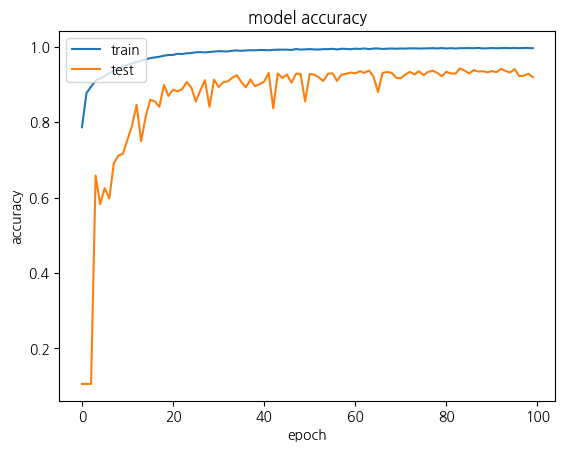

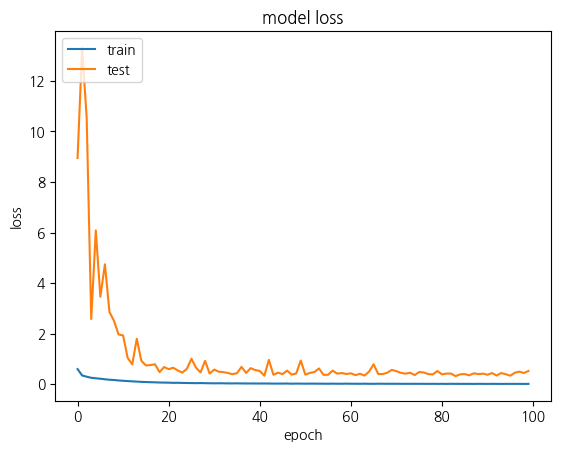

In [41]:
#학습결과 시각화
plt.plot(model_fit_history.history['accuracy'])
plt.plot(model_fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(model_fit_history.history['loss'])
plt.plot(model_fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
#테스트 데이터셋으로 평가 진행
model_evaluate_result = model.evaluate(test_images, test_labels, batch_size=1)

13230/13230 [==============================] - 97s 7ms/step - loss: 0.4892 - accuracy: 0.9232 - recall: 0.9227 - precision: 0.9241 - f1_score: 0.9246


In [43]:
print("test loss, test acc:", model_evaluate_result)

test loss, test acc: [0.4891508221626282, 0.9232048392295837, 0.9226757287979126, 0.9241426587104797, 0.9245904088020325]


In [44]:
with tf.device('CPU'):
    all_train_image, all_train_label = load_images_and_labels(all_train_images)
    model_predict = model.predict(all_train_image).argmax(axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90000/90000 [00:07<00:00, 12183.02it/s]
2023-04-21 19:41:03.830959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13547520000 exceeds 10% of free system memory.


2813/2813 [==============================] - 417s 148ms/step


In [45]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

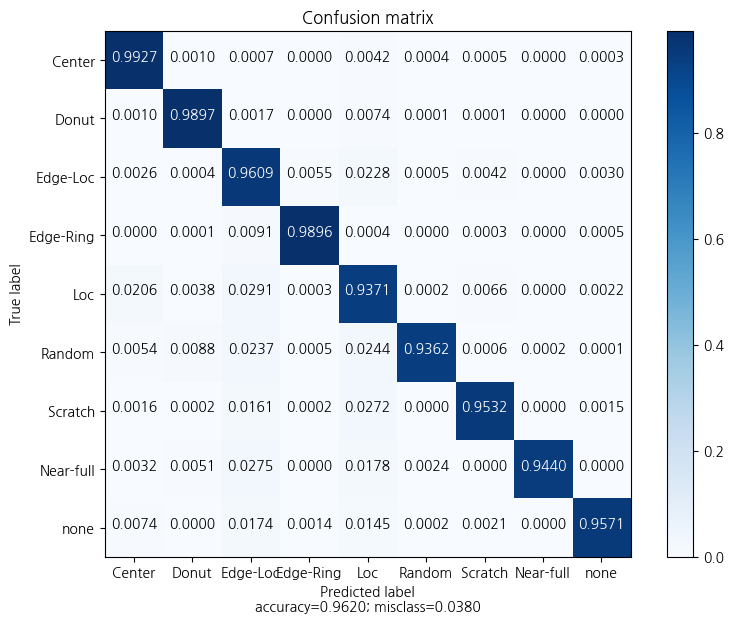

In [46]:
confusion_result = confusion_matrix(all_train_label, model_predict, normalize='pred')
plot_confusion_matrix(confusion_result, target_names=wf_train_labels, labels=True, normalize=True)

In [47]:
print(classification_report(all_train_label, model_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10000
           1       0.98      0.99      0.98     10000
           2       0.87      0.96      0.92     10000
           3       0.99      0.99      0.99     10000
           4       0.88      0.94      0.91     10000
           5       1.00      0.93      0.96     10000
           6       0.99      0.95      0.97     10000
           7       1.00      0.94      0.97     10000
           8       0.99      0.95      0.97     10000

    accuracy                           0.96     90000
   macro avg       0.96      0.96      0.96     90000
weighted avg       0.96      0.96      0.96     90000

